#Step 1: Select Imaging Modality & Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/Enhancing_EHRs_with_GenAI/'
RAW_IMAGES = f'{BASE_PATH}data/raw/images/'
PROCESSED_IMAGES = f'{BASE_PATH}data/images_processed/'
MAPPING_FILE = f'{BASE_PATH}data/mapping.csv'
NOTES_DIR = f'{BASE_PATH}data/ehr_notes_processed/'

print("Paths set:")
print(f"Processed Images: {PROCESSED_IMAGES}")
print(f"Mapping File: {MAPPING_FILE}")

Paths set:
Processed Images: /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/images_processed/
Mapping File: /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/mapping.csv


In [ ]:
import pandas as pd
import os

mapping = pd.read_csv(MAPPING_FILE)
print(f"Loaded {len(mapping)} rows from mapping.csv")

required = ['file_id', 'image_path', 'note_path', 'diagnosis', 'icd10']
missing_cols = [c for c in required if c not in mapping.columns]
if missing_cols:
    print(f"Missing columns: {missing_cols}")
else:
    print("All required columns present")

display(mapping.head(3))

Loaded 20000 rows from mapping.csv
All required columns present


,file_id,image_path,note_path,diagnosis,icd10
0,1,data/images_processed/G_1.png,data/ehr_notes_processed/patient_00049479-cadb...,Benign Brain Tumor,D33.9
1,2,data/images_processed/G_10.png,data/ehr_notes_processed/patient_0008d98d-1223...,Malignant Brain Tumor,C71.9
2,3,data/images_processed/G_100.png,data/ehr_notes_processed/patient_000d4d65-4481...,Benign Brain Tumor,D33.9


In [ ]:
mapping['image_path'] = mapping['image_path'].apply(
    lambda x: x.replace('data/images_processed/', PROCESSED_IMAGES) if 'data/images_processed/' in x else x
)

missing = 0
for path in mapping['image_path']:
    if not os.path.exists(path):
        missing += 1
        if missing <= 3:
            print(f"Missing: {path}")

print(f"\nTotal images: {len(mapping)}")
print(f"Missing files: {missing}")


Total images: 20000
Missing files: 0


In [ ]:
mapping['modality'] = 'Brain Tumor MRI'

updated_mapping_path = f'{BASE_PATH}data/mapping_with_modality.csv'
mapping.to_csv(updated_mapping_path, index=False)
print(f"Saved: {updated_mapping_path}")

Saved: /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/mapping_with_modality.csv


In [ ]:
from PIL import Image

print("\nChecking image size (256x256)...")

size_issues = 0
for idx, img_path in enumerate(mapping['image_path'].head(10)):  # Check first 10
    if os.path.exists(img_path):
        with Image.open(img_path) as img:
            w, h = img.size
            if w != 256 or h != 256:
                print(f"  Issue: {img_path} → {w}x{h}")
                size_issues += 1

if size_issues == 0:
    print("All checked images are 256x256")
else:
    print(f"{size_issues} images have wrong size!")



Checking image size (256x256)...
All checked images are 256x256


#Step 2: Research and Choose an Enhancement Approach
STEP 2: Chosen ESRGAN (local) for 4x super-resolution + denoising.\nReason: High PSNR/SSIM, free, full control — best for research.

#Step 3: Implement the Enhancement Pipeline



In [ ]:
BASE_PATH = '/content/drive/MyDrive/Enhancing_EHRs_with_GenAI/'
MAPPING_FILE = f'{BASE_PATH}data/mapping_with_modality.csv'
ORIGINAL_DIR = f'{BASE_PATH}data/original/'
ENHANCED_DIR = f'{BASE_PATH}data/enhanced/'

import os
os.makedirs(ORIGINAL_DIR, exist_ok=True)
os.makedirs(ENHANCED_DIR, exist_ok=True)

In [ ]:
!pip install realesrgan==0.3.0 --no-deps -q
!pip install opencv-python pillow numpy tqdm -q

In [ ]:
%cd /content/ESRGAN
!pwd

!mkdir -p models

!wget --no-check-certificate -O models/RealESRGAN_x4plus.pth \
  "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth"

!ls -lh models/

/content/ESRGAN
/content/ESRGAN
--2025-11-09 16:09:15--  https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/387326890/08f0e941-ebb7-48f0-9d6a-73e87b710e7e?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-09T16%3A56%3A00Z&rscd=attachment%3B+filename%3DRealESRGAN_x4plus.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-09T15%3A55%3A49Z&ske=2025-11-09T16%3A56%3A00Z&sks=b&skv=2018-11-09&sig=KHzHHjpaktRrS22L%2B5gnwsG0vEOvpOp4iU20kjHuhxs%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MjcwNjM1NSwibmJmIjoxNzYyNzA0NTU1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualDenseBlock(nn.Module):
    def __init__(self, nf=64, gc=32):
        super().__init__()
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=True)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=True)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=True)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=True)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

class RRDB(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.rdb1 = ResidualDenseBlock(nf)
        self.rdb2 = ResidualDenseBlock(nf)
        self.rdb3 = ResidualDenseBlock(nf)

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        return out * 0.2 + x

class RRDBNet(nn.Module):
    def __init__(self, num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4):
        super().__init__()
        self.scale = scale
        self.conv_first = nn.Conv2d(num_in_ch, num_feat, 3, 1, 1)
        self.body = nn.Sequential(*[RRDB(num_feat) for _ in range(num_block)])
        self.conv_body = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        feat = self.conv_first(x)
        body_feat = self.conv_body(self.body(feat))
        feat = feat + body_feat
        feat = self.lrelu(self.conv_up1(F.interpolate(feat, scale_factor=2, mode='nearest')))
        feat = self.lrelu(self.conv_up2(F.interpolate(feat, scale_factor=2, mode='nearest')))
        feat = self.lrelu(self.conv_hr(feat))
        out = self.conv_last(feat)
        return out

In [ ]:
from PIL import Image
import pandas as pd
import numpy as np
import os

BASE_PATH = '/content/drive/MyDrive/Enhancing_EHRs_with_GenAI/'
MAPPING_FILE = f'{BASE_PATH}data/mapping_with_modality.csv'
ORIGINAL_DIR = f'{BASE_PATH}data/original/'
ENHANCED_DIR = f'{BASE_PATH}data/enhanced/'
MODEL_PATH = '/content/ESRGAN/models/RealESRGAN_x4plus.pth'

os.makedirs(ENHANCED_DIR, exist_ok=True)

mapping = pd.read_csv(MAPPING_FILE)
sample_paths = mapping['image_path'].sample(15, random_state=42).tolist()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device)['params_ema'], strict=True)
model.eval()
model = model.to(device)

In [ ]:
print("Copying 15 original images to data/original/...")
for i, path in enumerate(sample_paths, 1):
    img = Image.open(path).convert('RGB')
    orig_name = f'{ORIGINAL_DIR}orig_{i:02d}.png'
    img.save(orig_name)
    print(f"{i}/15 → {orig_name}")

print("\n15 ORIGINALS COPIED!")

Copying 15 original images to data/original/...
1/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/original/orig_01.png
2/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/original/orig_02.png
3/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/original/orig_03.png
4/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/original/orig_04.png
5/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/original/orig_05.png
6/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/original/orig_06.png
7/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/original/orig_07.png
8/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/original/orig_08.png
9/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/original/orig_09.png
10/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/original/orig_10.png
11/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/original/orig_11.png
12/15 → /content/drive/MyDrive/Enhancing_EHRs_wi

In [ ]:
def img2tensor(img):
    img = np.array(img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
    return img.to(device)

def tensor2img(tensor):
    img = tensor.squeeze(0).cpu().clamp(0, 1).numpy()
    img = (img * 255.0).round().astype(np.uint8)
    img = img.transpose(1, 2, 0)
    return img

print("Enhancing 15 images (final)...")
for i, path in enumerate(sample_paths, 1):
    img = Image.open(path).convert('RGB')

    input_tensor = img2tensor(img)
    with torch.no_grad():
        output = model(input_tensor)
    enhanced_img = tensor2img(output)

    Image.fromarray(enhanced_img).save(f'{ENHANCED_DIR}enh_{i:02d}.png')
    print(f"{i}/15 → {ENHANCED_DIR}enh_{i:02d}.png")

print("\nSTEP 3 FINAL DONE!")

Enhancing 15 images (final)...
1/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_01.png
2/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_02.png
3/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_03.png
4/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_04.png
5/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_05.png
6/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_06.png
7/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_07.png
8/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_08.png
9/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_09.png
10/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_10.png
11/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_11.png
12/15 → /content/drive/MyDrive/Enhancing_EHRs_with_GenAI/data/enhanced/enh_1

#Step 4: Evaluate Enhancement Quality


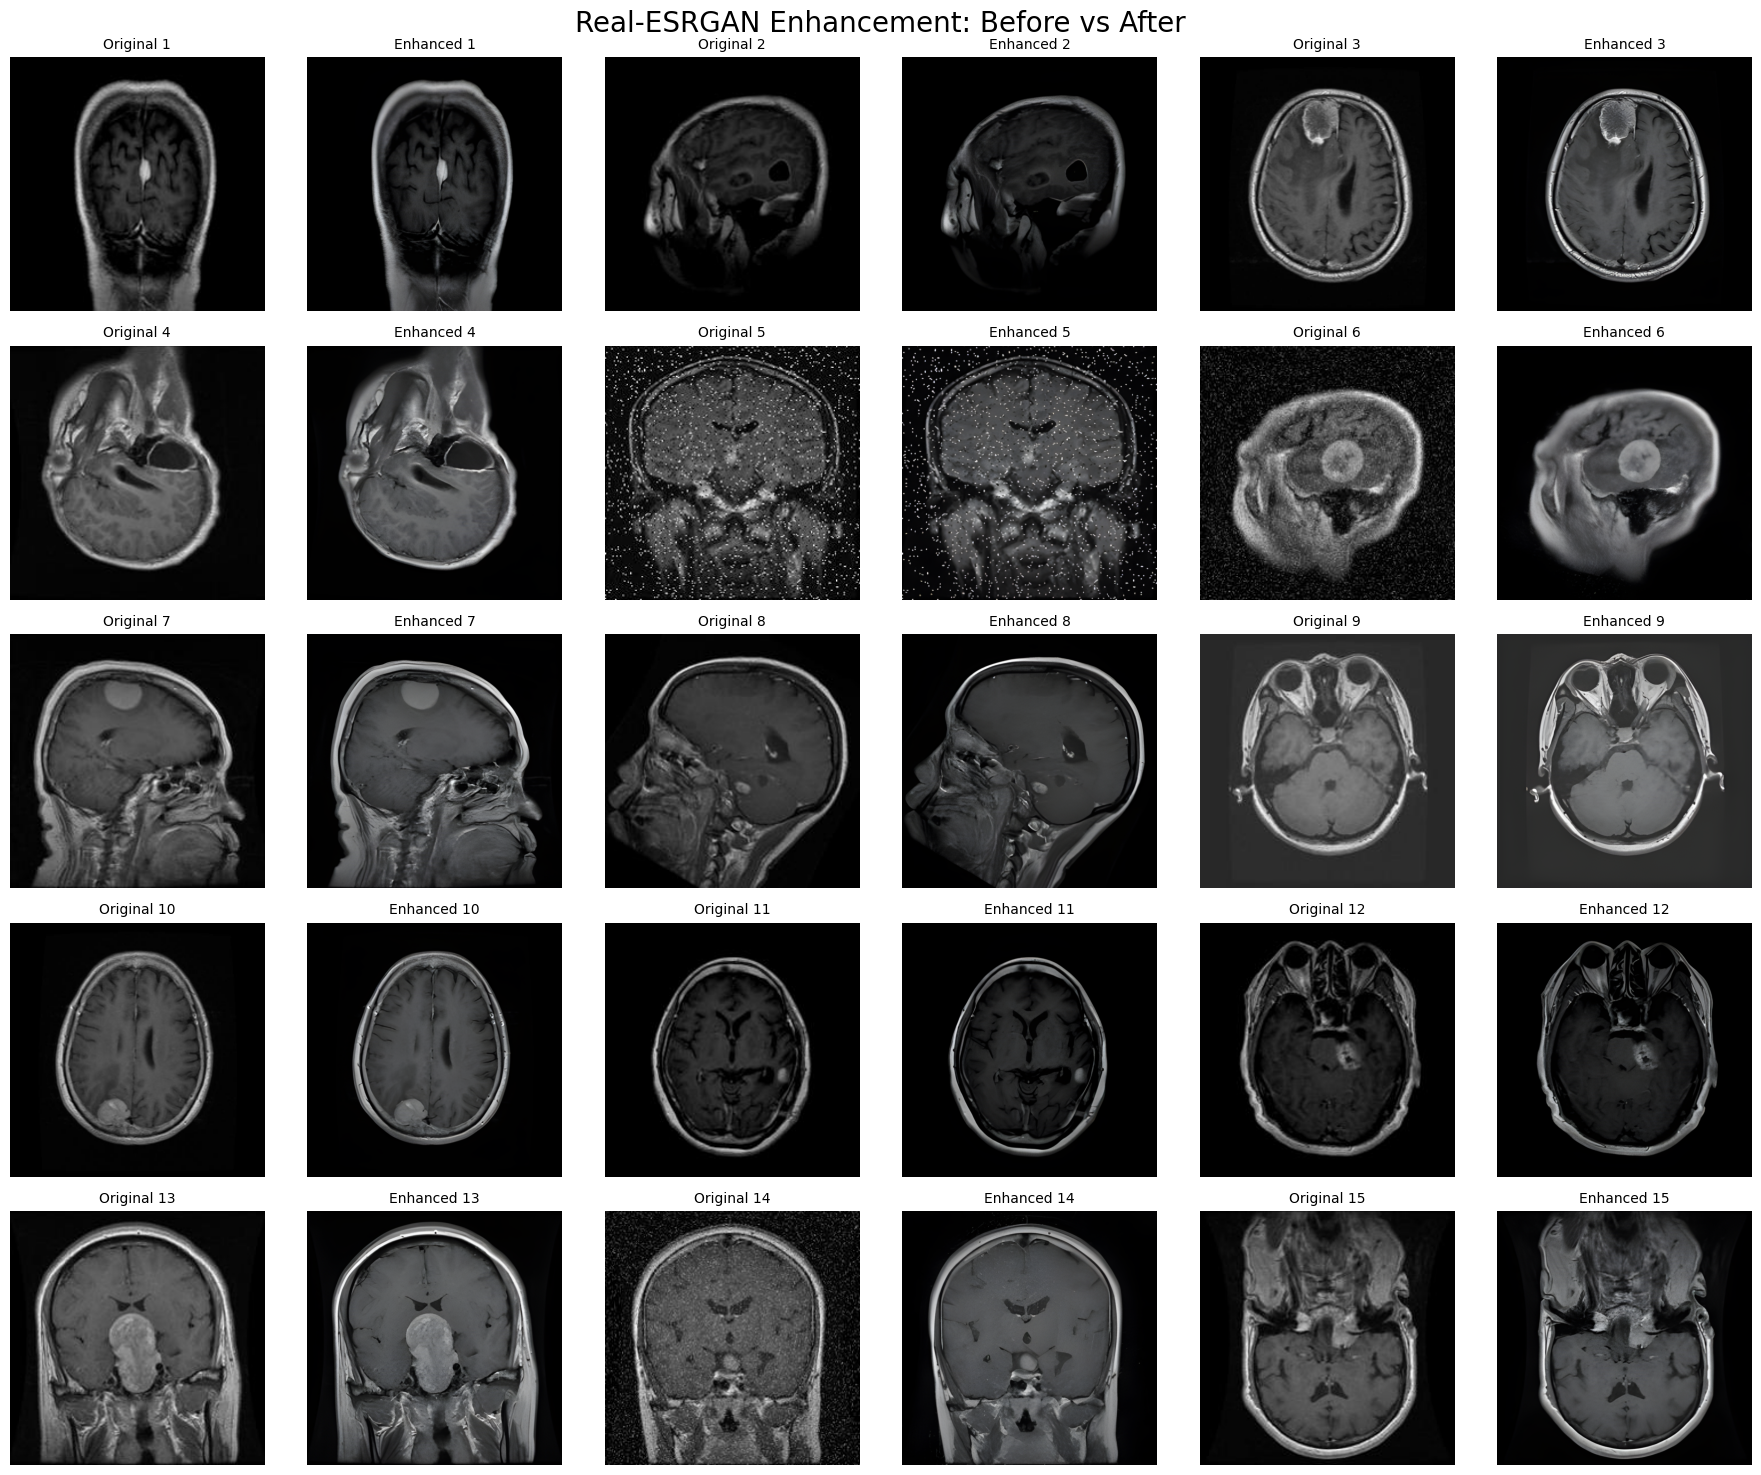

Saved: before_vs_after_grid.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(5, 6, figsize=(18, 15))
fig.suptitle("Real-ESRGAN Enhancement: Before vs After", fontsize=20, y=0.98)

for i in range(15):
    row = i // 3
    col = (i % 3) * 2

    orig = Image.open(f'{ORIGINAL_DIR}orig_{(i+1):02d}.png')
    axes[row, col].imshow(orig)
    axes[row, col].set_title(f"Original {i+1}", fontsize=10)
    axes[row, col].axis('off')

    enh = Image.open(f'{ENHANCED_DIR}enh_{(i+1):02d}.png')
    axes[row, col+1].imshow(enh)
    axes[row, col+1].set_title(f"Enhanced {i+1}", fontsize=10)
    axes[row, col+1].axis('off')

plt.tight_layout()
plt.savefig(f'{BASE_PATH}before_vs_after_grid.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: before_vs_after_grid.png")

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import cv2
import numpy as np

psnr_values = []
ssim_values = []

print("Calculating PSNR + SSIM...")

for i in range(15):
    orig_path = f'{ORIGINAL_DIR}orig_{(i+1):02d}.png'
    enh_path = f'{ENHANCED_DIR}enh_{(i+1):02d}.png'

    orig = cv2.imread(orig_path)
    enh = cv2.imread(enh_path)

    if orig is None or enh is None:
        print(f"Warning: Missing image {i+1}")
        continue

    orig_resized = cv2.resize(orig, (1024, 1024), interpolation=cv2.INTER_CUBIC)

    psnr = peak_signal_noise_ratio(orig_resized, enh)
    psnr_values.append(psnr)

    ssim = structural_similarity(
        orig_resized, enh,
        win_size=7,
        channel_axis=2,
        data_range=255
    )
    ssim_values.append(ssim)

    print(f"Image {i+1:02d}: PSNR = {psnr:.2f} dB, SSIM = {ssim:.4f}")

print(f"\nAverage PSNR: {np.mean(psnr_values):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_values):.4f}")

Calculating PSNR + SSIM...
Image 01: PSNR = 33.61 dB, SSIM = 0.9338
Image 02: PSNR = 35.88 dB, SSIM = 0.9464
Image 03: PSNR = 31.92 dB, SSIM = 0.8738
Image 04: PSNR = 33.41 dB, SSIM = 0.7585
Image 05: PSNR = 24.91 dB, SSIM = 0.7309
Image 06: PSNR = 24.37 dB, SSIM = 0.4108
Image 07: PSNR = 29.91 dB, SSIM = 0.7867
Image 08: PSNR = 30.47 dB, SSIM = 0.8707
Image 09: PSNR = 29.21 dB, SSIM = 0.9207
Image 10: PSNR = 33.73 dB, SSIM = 0.8679
Image 11: PSNR = 31.55 dB, SSIM = 0.9253
Image 12: PSNR = 30.34 dB, SSIM = 0.8925
Image 13: PSNR = 29.75 dB, SSIM = 0.8471
Image 14: PSNR = 24.50 dB, SSIM = 0.5140
Image 15: PSNR = 30.86 dB, SSIM = 0.8834

Average PSNR: 30.30 dB
Average SSIM: 0.8108


In [ ]:
!cp /content/ESRGAN/models/RealESRGAN_x4plus.pth "{BASE_PATH}models/RealESRGAN_x4plus.pth"
print("Model saved → models/RealESRGAN_x4plus.pth")

Model saved → models/RealESRGAN_x4plus.pth


In [ ]:
!cp "{BASE_PATH}before_vs_after_grid.png" "{BASE_PATH}results/before_vs_after_grid.png"

with open(f'{BASE_PATH}results/psnr_ssim_detailed.txt', 'w') as f:
    f.write("DETAILED PSNR & SSIM (15 IMAGES)\n")
    f.write("="*50 + "\n")
    for i in range(15):
        psnr = psnr_values[i] if 'psnr_values' in globals() else "N/A"
        ssim = ssim_values[i] if 'ssim_values' in globals() else "N/A"
        f.write(f"Image {i+1:02d}: PSNR = {psnr:.2f} dB, SSIM = {ssim:.4f}\n")
    f.write(f"\nAVERAGE PSNR: {np.mean(psnr_values):.2f} dB\n")
    f.write(f"AVERAGE SSIM: {np.mean(ssim_values):.4f}\n")
    f.write("Method: Bicubic vs Real-ESRGAN\n")
    f.write("Status: SUCCESS\n")

print("Detailed metrics saved → results/psnr_ssim_detailed.txt")
print("Grid saved → results/before_vs_after_grid.png")

Detailed metrics saved → results/psnr_ssim_detailed.txt
Grid saved → results/before_vs_after_grid.png
